### 딥러닝 모델로 분류하기 - 심장 데이터로
heart 파일 사용해보기

#### 데이터 가져오기

In [1]:
# 데이터 가져오기, 평탄화

import pandas as pd

# CSV 파일 읽기
df = pd.read_csv("../heart.csv")

print(df.head())  # 데이터 확인

print(df['target'].value_counts())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
target
1    165
0    138
Name: count, dtype: int64


#### 딥러닝 시작

In [2]:
# 원-핫 인코딩, 정규화, 딥러닝 입력을 위해 Numpy로 변환, train, test 분리

import pandas as pd

# [1] X, y 분리
X = df.drop(columns=["target"])
y = df["target"]

# [2] 정규화, 원-핫 인코딩, Numpy로 변환
from sklearn.preprocessing import StandardScaler

# y = pd.get_dummies(y).values # 원-핫 인코딩
    # y가 (0, 1) 2개(이진) 값만 가지는 경우에는 필요 없음
print(y[:5])

scaler = StandardScaler()
X = scaler.fit_transform(X) # 정규화. 여기서 StandardScaler()가 X를 Numpy로 변환시킴
# X = X.values # 딥러닝 입력을 위해 Numpy로 변환
print(X[:5])

# [3] train, test 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64
[[ 0.9521966   0.68100522  1.97312292  0.76395577 -0.25633371  2.394438
  -1.00583187  0.01544279 -0.69663055  1.08733806 -2.27457861 -0.71442887
  -2.14887271]
 [-1.91531289  0.68100522  1.00257707 -0.09273778  0.07219949 -0.41763453
   0.89896224  1.63347147 -0.69663055  2.12257273 -2.27457861 -0.71442887
  -0.51292188]
 [-1.47415758 -1.46841752  0.03203122 -0.09273778 -0.81677269 -0.41763453
  -1.00583187  0.97751389 -0.69663055  0.31091206  0.97635214 -0.71442887
  -0.51292188]
 [ 0.18017482  0.68100522  0.03203122 -0.66386682 -0.19835726 -0.41763453
   0.89896224  1.23989692 -0.69663055 -0.20670527  0.97635214 -0.71442887
  -0.51292188]
 [ 0.29046364 -1.46841752 -0.93851463 -0.66386682  2.08204965 -0.41763453
   0.89896224  0.58393935  1.43548113 -0.37924438  0.97635214 -0.71442887
  -0.51292188]]


((242, 13), (242,), (61, 13), (61,))

손실함수

1. Binary Crossentropy

이 손실 함수는 **이진 분류 문제(binary classification)에 사용**됩니다. 여기서 모델은 단 두 개의 클래스 중 하나를 예측해야 합니다. **출력 계층 노드 수가 1**이고, 보통 시그모이드 활성화 함수(**sigmoid** activation function)를 출력 계층에 사용합니다. 이 함수는 0과 1 사이의 값을 반환하여, 각 클래스에 속할 확률을 나타냅니다.

2. Categorical Crossentropy

**다중 클래스 분류 문제(multi-class classification)에 사용**됩니다. 모델은 두 개 이상의 클래스 중 하나를 예측해야 합니다 소프트맥스 활성화 함수(**softmax** activation function)가 일반적으로 사용됩니다. 이 함수는 모든 클래스에 대해 확률 분포를 반환하여, 각 클래스에 속할 확률을 나타냅니다.

In [ ]:
# 모델 정의하기(만들기), 하이퍼파라미터 튜닝

from keras.models import Sequential # 신경망 모델: 층을 순차적으로 쌓는 방식
from keras.layers import Dense # 완전 연결 레이어
from keras.optimizers import SGD,Adam # 최적화 알고리즘
from keras.layers import Dropout
from keras.regularizers import l2 # 정규화 

# (하이퍼파라미터)튜닝
# 1. 각 레이어의 activation 함수로 relu, sigmoid, softmax 3개를 섞어 쓸 수 있음
# 2. 모델의 Dense(a, ...)의 a를 늘렸다 줄일 수도, 늘리기만 할 수도, 왔다갔다 할 수도 있음
# 3. add 함수를 여러 개 넣어서 레이어 수를 늘리거나 반대로 add 함수를 빼서 줄일 수도 있음
# * 마지막 add(레이어)는 바꾸면 안 됨! 모델마다 Last-Layer Activation과 Loss Function(compile(..., 'binary_crossentropy', ...) 이 부분)은 고정임

# 모델 수정으로 과적합 줄이는 방법(출처: chatGPT)
# 1. 모델 복잡도 줄이기: 은닉층의 수 or 한 은닉층의 노드 수를 줄여보기
# 2. 층 사이에 Dropout 추가
# 3. 특정 층에 L2 정규화 추가

# 모델 수정으로 과소적합 줄이는 방법(출처: chatGPT)
# 0. (**중요**)입력 데이터 정규화: X = scaler.fit_transform(X) 등으로 정규화해주지 않으면 딥러닝 모델이 제대로 작동하지 않음
# 1. 모델 복잡도 늘리기: 은닉층 수 or 노드 수 늘리기(64, 128까지 키워볼 것)
# 2. epochs(학습 반복수) 늘리기(100 이상 돌려볼 것)
# 3. optimizer 변경: SGD보다 Adam, RMSprop 등이 더 성능이 좋은 편
# 4. 학습률 조정
# 5. activation function(활성화 함수) 변경


model = Sequential()

# 모델에 층 추가
# model.add(Dense(32,input_shape=(64,),activation='relu', kernel_regularizer=l2(0.01)))
    # input_shape=(13,): 데이터의 특성 개수가 13개
    # Dense: 층간 모든 뉴런들이 가능한 모든 네트워크를 연결한 레이어 상태. 윗층이 2개, 아랫층이 3개면 6개의 네트워크가 다 연결된 것.
    # Dense(10, ...): 이 층이 출력으로 뽑는 노드(특성)가 10개
    # kernel_regularizer: 정규화 함수. l2는 L2 정규화
# model.add(Dropout(0.1)) # 일부 뉴런의 연결선을 랜덤하게 비활성화. 과적합 해소용. 0.3 = 30% 비활성화

model.add(Dense(13,input_shape=(13,),activation='sigmoid')) # 입력층
    # input_shape=(13,): 데이터의 특성 개수가 13개
model.add(Dropout(0.15))
model.add(Dense(4,activation='sigmoid')) # 은닉층
model.add(Dense(1,activation='sigmoid')) # 출력층
    # 출력층 노드가 a개: a개의 답 중 하나를 분류하는 문제라는 의미
    # 만약 이진 분류라 one-hot 인코딩을 안 한 상태라면 노드가 1개여야 함

model.compile(Adam(learning_rate=0.002),'binary_crossentropy',metrics=['accuracy'])
    # Adam(): 최적화 알고리즘. 딥러닝에서 가장 많이 쓰임.
    #   ㄴ learning_rate: 학습률. 가중치 업데이트 시 변화량 조절.
    # 'binary_crossentropy': 손실 함수 - 모델이 얼마나 틀렸는지 측정. 2중이 아닌 다중 클래스 분류라면 categorical_crossentropy를 써야 함.
    # metrics=['accuracy']: 평가 지표로 accuracy(정확도) 사용.
    
    # *learning_rate 대신 lr을 사용하면 오류: 최신 버전은 learning_rate 속성만 지원
model.summary()
    # 출력으로 나오는 Params: 파라미터. AI 모델의 내부 변수. 이 변수에 의해 입력값이 원하는 출력값으로 만들어 짐. 가중치(w)와 비슷한 것.

c:\Users\jt341\anaconda3\envs\2025AI\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243 (972.00 B)

 Trainable params: 243 (972.00 B)

 Non-trainable params: 0 (0.00 B)

In [4]:
model_history=model.fit(x=X_train, y=y_train, epochs=50, batch_size=32, validation_data=(X_test,y_test))
    # validation_data: train, test와 별개로 학습 시 손실, 정확도 확인을 위해 쓰는 데이터
y_pred = model.predict(X_test)

# import numpy as np

# y_test_class = np.argmax(y_test,axis=1) # argmax: one-hot 인코딩으로 바뀐 상태를 되돌려서 결과를 평가할 수 있도록 함
# y_pred_class = np.argmax(y_pred,axis=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5216 - loss: 0.6913 - val_accuracy: 0.7049 - val_loss: 0.6831
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5593 - loss: 0.6839 - val_accuracy: 0.6721 - val_loss: 0.6784
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6045 - loss: 0.6830 - val_accuracy: 0.7049 - val_loss: 0.6739
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6763 - loss: 0.6721 - val_accuracy: 0.6885 - val_loss: 0.6692
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5594 - loss: 0.6757 - val_accuracy: 0.6885 - val_loss: 0.6646
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6495 - loss: 0.6678 - val_accuracy: 0.6557 - val_loss: 0.6600
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5784 - loss: 0.6627 - val_accuracy: 0.7049 - val_loss: 0.6547
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6392 - loss: 0.6626 - val_accuracy: 0.7049 - val_loss: 0.6492


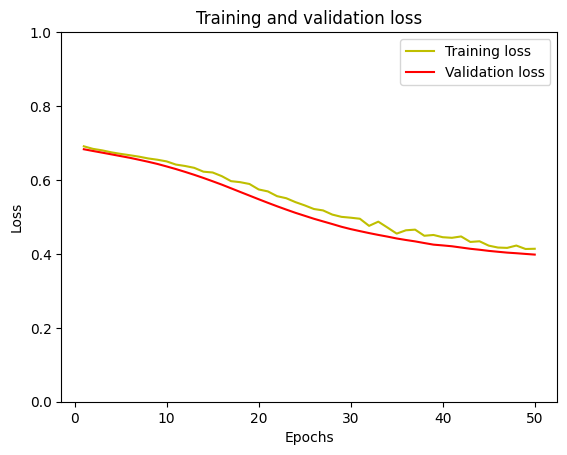

In [ ]:
# 학습 결과 시각화

import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1) # y축 (최소값, 최대값) 설정
plt.legend()
plt.show()

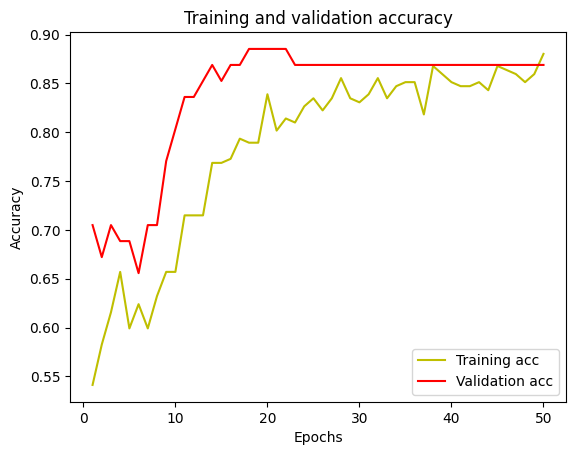

In [6]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Confusion Matrix:
[[25  4]
 [ 4 28]]


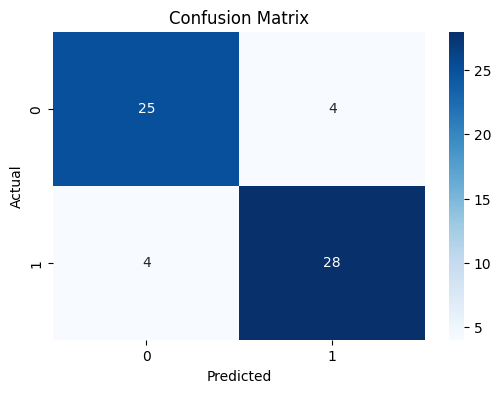

In [15]:
# 이진 분류 모델 혼동 행렬 시각화

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# [1] y_pred를 0 또는 1로 변환 (sigmoid 출력이니까 0.5 기준)
y_pred_labels = (y_pred > 0.5).astype(int)

# [2] 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_labels)

# [3] 출력
print("Confusion Matrix:")
print(cm)

# [외전] 예쁘게 시각화
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()